## Multiclass Classifier for Announcements issued by Listed Companies on the Hong Kong Stock Exchange

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Bidirectional, LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.utils import plot_model

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly

In [2]:
# Get data from scraped CSVs
CCT = '/content/drive/My Drive/Data/HKEX/ch14A_cct.csv'
NT = '/content/drive/My Drive/Data/HKEX/notifiable_transactions.csv'
TK = '/content/drive/My Drive/Data/HKEX/takeovers_code_3_7.csv'
AGM = '/content/drive/My Drive/Data/HKEX/notice_of_agm.csv'
TH = r'/content/drive/My Drive/Data/HKEX/trading halt.csv'
AR = '/content/drive/My Drive/Data/HKEX/annual_results_annt.csv'

ct = pd.read_csv(CCT)
nt = pd.read_csv(NT)
tk = pd.read_csv(TK)
agm = pd.read_csv(AGM)
th = pd.read_csv(TH)
ar = pd.read_csv(AR)

In [3]:
# Trim data sources such that the amount of training examples from different categories are not vastly different
agm = agm.sample(frac=1)
agm = agm[:3000]
ar = ar.sample(frac=1)
ar = ar[:3000]

In [4]:
# Concat all data sources
df = ct.append(nt).append(tk).append(agm).append(th).append(ar)
df

,URL,Text,Label
0,https://www1.hkexnews.hk/listedco/listconews/s...,Hong Kong Exchanges and Clearing Limited and T...,Chapter 14A Connected Transaction Announcement
1,https://www1.hkexnews.hk/listedco/listconews/s...,Hong Kong Exchanges and Clearing Limited and T...,Chapter 14A Connected Transaction Announcement
2,https://www1.hkexnews.hk/listedco/listconews/s...,Hong Kong Exchanges and Clearing Limited and T...,Chapter 14A Connected Transaction Announcement
3,https://www1.hkexnews.hk/listedco/listconews/s...,Hong Kong Exchanges and Clearing Limited ...,Chapter 14A Connected Transaction Announcement
4,https://www1.hkexnews.hk/listedco/listconews/s...,Hong Kong Exchanges and Clearing Limited and T...,Chapter 14A Connected Transaction Announcement
...,...,...,...
1803,https://www1.hkexnews.hk/listedco/listconews/s...,Hong Kong Exchanges and Clearing Limited and T...,Annual Results Announcement
1370,https://www1.hkexnews.hk/listedco/listconews/s...,Hong Kong Exchanges and Clearing Limited and T...,Annual Results Announcement
1107,https://www1.hkexnews.hk/listedco/listconews/s...,Hong Kong Exchanges and Clearing Limited ...,Annual Results Announcement
90,https://www1.hkexnews.hk/listedco/listconews/g...,Hong Kong Exchanges and Clearing Limited and T...,Annual Results Announcement


In [5]:
# Shuffle dataframe
df = df.sample(frac = 1)

In [6]:
# Create matrix of labels
df['Notifiable Transaction'] = df.Label.apply(lambda x: 1 if x == "Notifiable Transactions" else 0)
df['Takeover Offer'] = df.Label.apply(lambda x: 1 if x == "Takeovers Code 3.7 Announcement" else 0)
df['Connected Transaction'] = df.Label.apply(lambda x:1 if x == "Chapter 14A Connected Transaction Announcement" else 0)
df['Notice of AGM'] = df.Label.apply(lambda x:1 if x == "Notice of AGM" else 0)
df['Trading Halt'] = df.Label.apply(lambda x:1 if x == 'Trading Halt' else 0)
df['Annual Results'] = df.Label.apply(lambda x:1 if x == 'Annual Results Announcement' else 0)
df.head()

,URL,Text,Label,Notifiable Transaction,Takeover Offer,Connected Transaction,Notice of AGM,Trading Halt,Annual Results
2301,https://www1.hkexnews.hk/listedco/listconews/s...,Hong Kong Exchanges and Clearing Limited ...,Notifiable Transactions,1,0,0,0,0,0
1507,https://www1.hkexnews.hk/listedco/listconews/s...,Hong Kong Exchanges and Clearing Limited and T...,Notifiable Transactions,1,0,0,0,0,0
499,https://www1.hkexnews.hk/listedco/listconews/s...,Hong Kong Exchanges and Clearing Limited and T...,Trading Halt,0,0,0,0,1,0
532,https://www1.hkexnews.hk/listedco/listconews/s...,Hong Kong Exchanges and Clearing Limited ...,Trading Halt,0,0,0,0,1,0
6696,https://www1.hkexnews.hk/listedco/listconews/s...,Hong Kong Exchanges and Clearing Limited and T...,Notice of AGM,0,0,0,1,0,0


In [7]:
# Extract matrix of labels
labels = df[['Notifiable Transaction', 'Takeover Offer', 'Connected Transaction', 'Notice of AGM', 'Trading Halt', 'Annual Results']]
labels.head()

,Notifiable Transaction,Takeover Offer,Connected Transaction,Notice of AGM,Trading Halt,Annual Results
2301,1,0,0,0,0,0
1507,1,0,0,0,0,0
499,0,0,0,0,1,0
532,0,0,0,0,1,0
6696,0,0,0,1,0,0


## Text Preprocessing

Text preprocessing is an important step of any NLP application. My preliminary testing on the model with fewer labels and fewer training examples indicated that removing stop words leads to a drastically decreased accuracy on the classifier. This may be because a bidirectional LSTM would be more able to capture the semantic meanings of the corpus with the stop words intact. 

In [8]:
# Text Preprocessing, removing stop words vastly decreased training accuracy
def preprocess(corpus):
    corpus = corpus.lower()
    cleaner = re.compile(r'[^a-z 0-9]')
    corpus = re.sub('\n', ' ', corpus)
    corpus = re.sub(cleaner, ' ', corpus)
    corpus = re.sub(r'\s+', ' ', corpus)
  #  corpus = ' '.join([word for word in corpus.split() if word not in stopwords.words('english')])
    return corpus

In [9]:
# Extract X Y values
corpus_list = list(df.Text)
X = [preprocess(corpus) for corpus in corpus_list]

Y = labels.values

In [10]:
# Create train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Tokenization and Padding

Each text corpus in the training examples X_train are converted into an array of tokens, where each token will be word-vectors representating the token. 

Each of the inputs will be normalized in terms of length, with a max length on each input chosen to be 1500. This number came about after extensive testing, in addition to some intuitive feature engineering, such as knowing that the most important content of any announcement is located towards the beginning of the announcement. 

For announcements with less than 1500 words, null vectors will be used to pad the announcement until the 1500 word count is reached.


In [11]:
# Process X data into tokenized and padded input
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
max_len = 2000
X_train = pad_sequences(X_train, padding = 'post', maxlen = max_len)
X_test = pad_sequences(X_test, padding = 'post', maxlen = max_len)

print(f'vocab_size = {vocab_size}')

vocab_size = 75316


# Pre-trained Embeddings

Through experimentation with pre-trained embeddings or a fresh embedding layer to learn on its own, the use of pre-trained embeddings greatly increased accuracy. 

The pre-trained embeddings used here are GloVe embeddings from Stanford, which can be downloaded here: https://nlp.stanford.edu/projects/glove/

In [12]:
# Load glove embeddings, create embedding matrix
glove_path = r'/content/drive/My Drive/Data/glove.6B.300d.txt'

embeddings_dictionary = dict()

with open(glove_path) as glove:
    for line in glove:
        records = line.split()
        word = records[0]
        vector_dims = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dims
embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [13]:
def RNN():
    inputs = Input(shape = (max_len,))
    layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(inputs)
#    layer = Embedding(vocab_size, 100, input_length=max_len)(inputs)
    layer = Bidirectional(LSTM(128))(layer)
    layer = Dropout(0.8)(layer)
    layer = Dense(256)(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.8)(layer)
    layer = Dense(6)(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2000, 300)         22594800  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

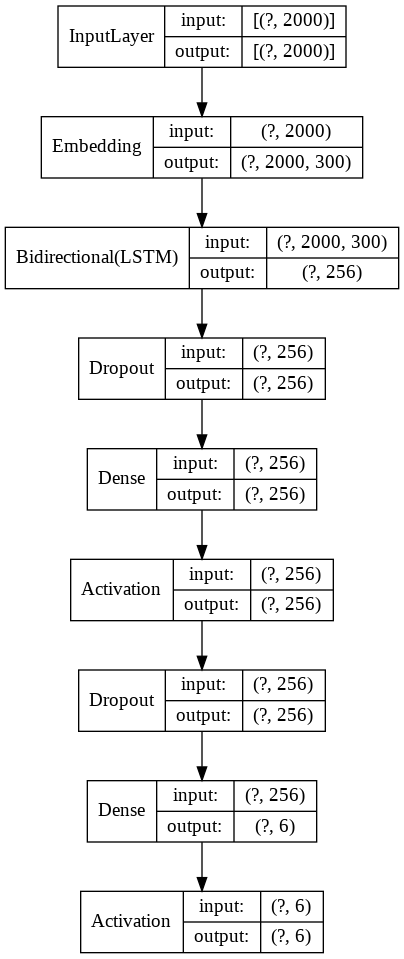

In [14]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [15]:
ES = EarlyStopping(monitor='val_loss', verbose=1, patience=10, restore_best_weights=True)

In [16]:
history = model.fit(X_train, Y_train,
                    epochs=40,
                    validation_data=(X_test, Y_test),
                    batch_size=32,
                    callbacks=[ES])

Epoch 1/40
299/299 [==============================] - 84s 282ms/step - loss: 0.4014 - accuracy: 0.4245 - val_loss: 0.3293 - val_accuracy: 0.5463
Epoch 2/40
299/299 [==============================] - 83s 279ms/step - loss: 0.3355 - accuracy: 0.5181 - val_loss: 0.3066 - val_accuracy: 0.5555
Epoch 3/40
299/299 [==============================] - 83s 278ms/step - loss: 0.3268 - accuracy: 0.5422 - val_loss: 0.3133 - val_accuracy: 0.5513
Epoch 4/40
299/299 [==============================] - 83s 279ms/step - loss: 0.3191 - accuracy: 0.5463 - val_loss: 0.3012 - val_accuracy: 0.5643
Epoch 5/40
299/299 [==============================] - 83s 279ms/step - loss: 0.3084 - accuracy: 0.5566 - val_loss: 0.2933 - val_accuracy: 0.5718
Epoch 6/40
299/299 [==============================] - 83s 278ms/step - loss: 0.2993 - accuracy: 0.5668 - val_loss: 0.2949 - val_accuracy: 0.5706
Epoch 7/40
299/299 [==============================] - 83s 279ms/step - loss: 0.2964 - accuracy: 0.5763 - val_loss: 0.2682 - val_ac

In [17]:
acc = model.evaluate(X_test, Y_test)
print(f'Validation set results \nLoss: {acc[0]:.4f} \nAccuracy: {acc[1]:.4f}')

75/75 [==============================] - 8s 109ms/step - loss: 0.0821 - accuracy: 0.9355
Validation set results 
Loss: 0.0821 
Accuracy: 0.9355


In [19]:
# Plot losses and accuracy with plotly
h = history.history
epochs = [i+1 for i in range(len(h['loss']))]
cols = plotly.colors.DEFAULT_PLOTLY_COLORS

fig = make_subplots(rows=1, cols=2, subplot_titles=('Training and Validation Accuracy', 'Training and Validation Loss'))

fig.add_trace(go.Scatter(x=epochs, y=h['accuracy'], 
                         line=dict(width=1.5, color=cols[0]),
                         name='Training Accuracy'), 1,1)
fig.add_trace(go.Scatter(x=epochs, y=h['val_accuracy'], 
                         line=dict(width=1.5, color=cols[3]),
                         name='Validation Accuracy'), 1,1)

fig.add_trace(go.Scatter(x=epochs, y=h['loss'], 
                         line=dict(width=1.5, color=cols[0]),
                         name='Training Loss'), 1,2)
fig.add_trace(go.Scatter(x=epochs, y=h['val_loss'], 
                         line=dict(width=1.5, color=cols[3]),
                         name='Validation Loss'), 1,2)

fig.update_layout(height = 400, width=1000)
fig.update_xaxes(title_text='Epochs')
fig.update_yaxes(title_text='Accuracy', row=1,col=1)
fig.update_yaxes(title_text='Loss', row=1,col=2)

fig.show()

# Fine-tuning of model

Important hyper-parameters of this model:
- max length of input word vectors
- whether or not to use pre-trained word embeddings
- whether the pre-trained word embeddings should be trainable
- dimensions of pre-trained embeddings or learned embeddings

# The tests below initially follow the same architecture:
i. Input Layer

ii. Embedding Layer 

iii. Bidirectional LSTM of 128 units with dropout of 0.8

iv. Dense layer of 256 units, Relu activation with dropout of 0.8 

v: Dense layer of 6 units with sigmoid activation


## Test 1: 
Epochs: **20**, maxlen: **2000**, Embeddings: **not-pre-trained**, dimension: **100** 

Training Acc: 72.3%

Validation Acc: 60%

*It seems that the model was not able to even fit well in the training data with a poor validation accuracy, let's try pre-trained embeddings next.*

## Test 2: 
Epochs: **20**, maxlen: **2000**, Embeddings: **pretrained**, dimensions: **100**, trainable: **False**

Training Acc: 87.0%

Validation Acc: 87.5%

*There is no problem of overfitting here as the validation accuracy is actually higher than the training accuracy, which is probably due to the dropout layers not being used at test time. However, there is an avoidable bias problem of 13%. Moreover, towards the end of the training, the losses are still slowly decreasing, which indicates the network might still benefit from more epochs of training - let's try 30, while increasing the dimensions of units of embeddings to 300 in order to address both issues.*

## Test 3: 
Epochs: **30**, maxlen: **2000**, Embeddings: **pretrained**, dimensions: **300**, trainable: **False**

**Epoch 20:**

Training Acc: 89.4%

Validation Acc: 90.0%


**Epoch 30:**

Training Acc: 93.9%

Validation Acc: 94.0%

*Increasing the dimensions of the pre-trained embedding layer improved drastically. 94% on the validation set is quite impressive. Towards the end of training, it seems that the network has yet to start to overfit drastically, so perhaps we can try increasing the number of training epochs by another 10. As GloVe embeddings were not trained specifically on a legal corpus, we can try to use trainable embeddings to see if that further improves performance.*

## Test 4: 
Epochs: **40**, maxlen: **2000**, Embeddings: **pretrained**, dimensions: **300**, trainable: **True**

**Epoch 20:**

Training Acc: 93.3%

Validation Acc: 92.2%

**Epoch 30:**

Training Acc: 98.2%

Validation Acc: 94.2%


**Epoch 40:**

Training Acc: 99.2%

Validation Acc: 93.4%

*Making the embeddings trainable did not result in any significant increase in validation accuracy, while making training significantly slower. In addition, the network starting overfitting substantially after epoch 18. As such, for future tests, the pre-trained embedding layer will be set as not trainable. 

## Test 5 (Different set of shuffled data)(Repeat of Test 3, but with 40 epochs): 
Epochs: **40**, maxlen: **2000**, Embeddings: **pretrained**, dimensions: **300**, trainable: **False**

**Epoch 30:**

Training Acc: 90.0%

Validation Acc: 92.0%


**Epoch 40:**

Training Acc: 95.0%

Validation Acc: 93.6%










In [32]:
model.save('/content/drive/My Drive/Data/HKEX/model.h5')

## Testing on New Announcements 

Let's see how our classifier does on new data that it has not seen! 

I picked some recent announcements for testing. 

For the testing, it is important that the testing announcements are not in the training set or validation set. The classify_pdf function written below takes this into account.


In [20]:
import requests
!pip install PyPDF2 
import PyPDF2
import io
import warnings

     |████████████████████████████████| 81kB 2.7MB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-cp36-none-any.whl size=61086 sha256=a59405027da28f7d6d37ac6d5149d913b168d30bd6a0a8e5832d75637202b15a
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2


In [50]:
def classify_pdf(url):
    # if url for testing is in the existing data set, do not go ahead with testing
    if len(df.loc[df['URL'] == url]) != 0:
        return f'{url} in Training or Validation, try another url'
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        response = requests.get(url)
        raw_data = response.content

        pdf_content = io.BytesIO(raw_data)
        pdf_reader = PyPDF2.PdfFileReader(pdf_content)

        test_string = ''

        if pdf_reader.isEncrypted:
            pdf_reader.decrypt("")

        for i in range(pdf_reader.numPages):
            test_string += pdf_reader.getPage(i).extractText()

        test = [test_string]
        seq = tokenizer.texts_to_sequences(test)
        padded = pad_sequences(seq, maxlen=max_len)
        pred = model.predict(padded)
        labels_pred = ['Notifiable Transaction', 'Takeover Offer', 'Connected Transaction', 'Notice of AGM', 'Trading Halt', 'Annual Results']
        normalised = pred/np.sum(pred)*100
        confidence = float(normalised.astype(float).reshape(len(labels_pred),-1)[np.argmax(pred)])
        print(f'Prediction: {labels_pred[np.argmax(pred)]} with {confidence:.2f}% confidence')

In [51]:
classify_pdf('https://www1.hkexnews.hk/listedco/listconews/sehk/2020/0925/2020092501332.pdf')


Prediction: Notifiable Transaction with 99.93% confidence


Great! The classifier was able to correctly identify the announcement as a Notifiable Transaction, which is also known as a Discloseable Transaction. Let's try a few more announcements.

In [53]:
classify_pdf('https://www1.hkexnews.hk/listedco/listconews/sehk/2020/0925/2020092501350.pdf')

Prediction: Annual Results with 100.00% confidence


The classifier is very confident about this result, which turned out to be correct.

In [54]:
classify_pdf('https://www1.hkexnews.hk/listedco/listconews/sehk/2020/0925/2020092501035.pdf')

Prediction: Connected Transaction with 53.02% confidence


As for this sample, the classifier is not too confident about it, but it turned out to be correct.